In [1]:
import anndata as ad
import numpy as np
import scanpy as sc 

from core.preprocessor import Preprocessor
from core.normalizer import Normalizer
from core.differentiator import Differentiator
from core.model_tester import ModelTester
from core.categorizer import Categorizer
from plotmodules.norm_plots import *

CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)


ct_counts_metadata.shape=(427, 54)


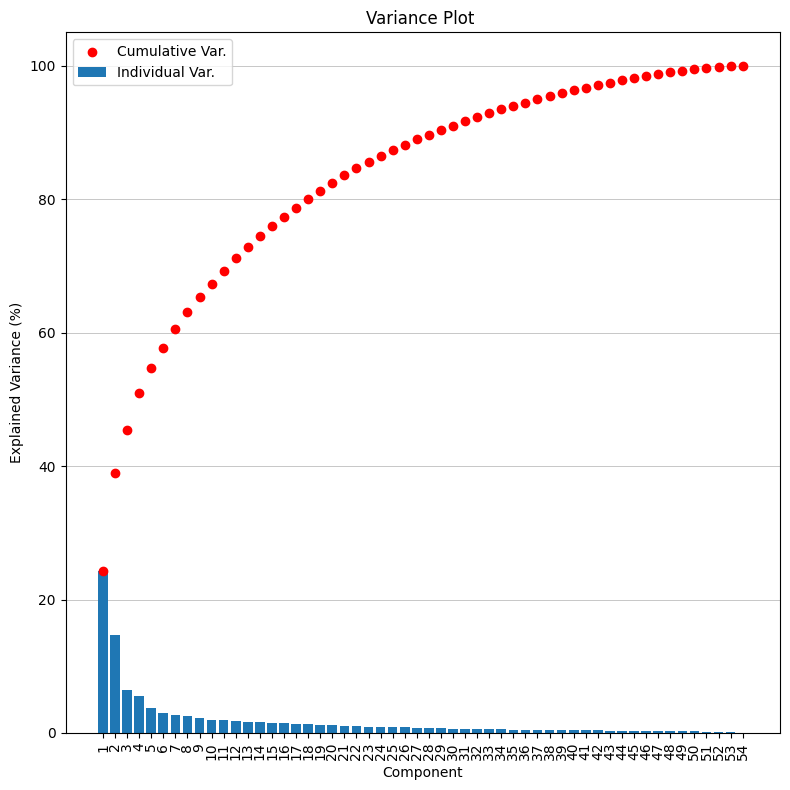

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


ct_counts_metadata.shape=(416, 53)


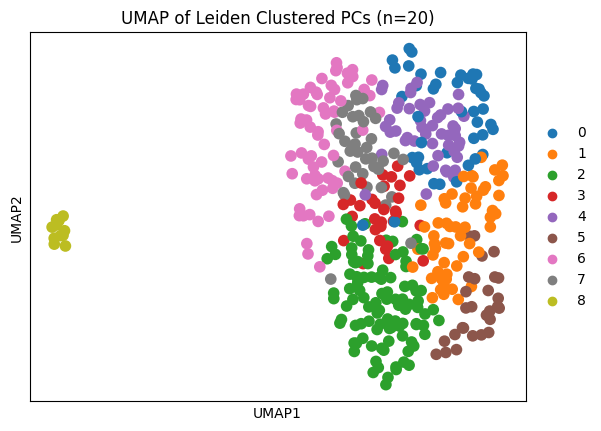

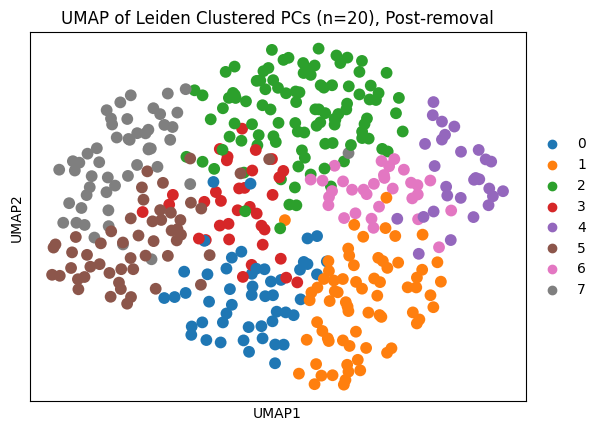

In [2]:
print(f'{ct_counts_metadata.shape=}')
pp = Preprocessor()
pp.show_pca(ct_counts_metadata)
pp.set_n_components(20)
pp.analyze_umap(ct_counts_metadata)
ct_counts_metadata = pp.remove_cluster(ct_counts_metadata, '8')
ct_counts_metadata = ct_counts_metadata[:, ct_counts_metadata.var_names != 'Exc RELN CHD7']
print(f'{ct_counts_metadata.shape=}')

In [3]:
# Calculate total counts for each individual
total_counts_per_sample = np.zeros(ct_counts_metadata.X.shape[0])
for i in range(ct_counts_metadata.X.shape[0]):
    total_counts_per_sample[i] = np.sum(ct_counts_metadata.X[i])
ct_counts_metadata.obs['total_counts'] = total_counts_per_sample

/tmp/ipykernel_53792/29532748.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [4]:
# Regress out post mortem interval
pp.regress_out(ct_counts_metadata, 'pmi')

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.


In [5]:
# Filter by braak stage and cogdx
cat = Categorizer(True)
ct_counts_metadata = ct_counts_metadata[(ct_counts_metadata.obs['cogdx'].isin([4, 5]) & ct_counts_metadata.obs['braaksc'].isin([4, 5, 6])) | 
                                        (ct_counts_metadata.obs['cogdx'].isin([1]) & ct_counts_metadata.obs['braaksc'].isin([0, 1, 2, 3]))]
cat.categorize(ct_counts_metadata, 'cogdx', cat.COGDX_MAP)
ct_counts_metadata.obs.value_counts(['cogdx_cat'])

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/categorizer.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


cogdx_cat
AD           108
H             99
Name: count, dtype: int64

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


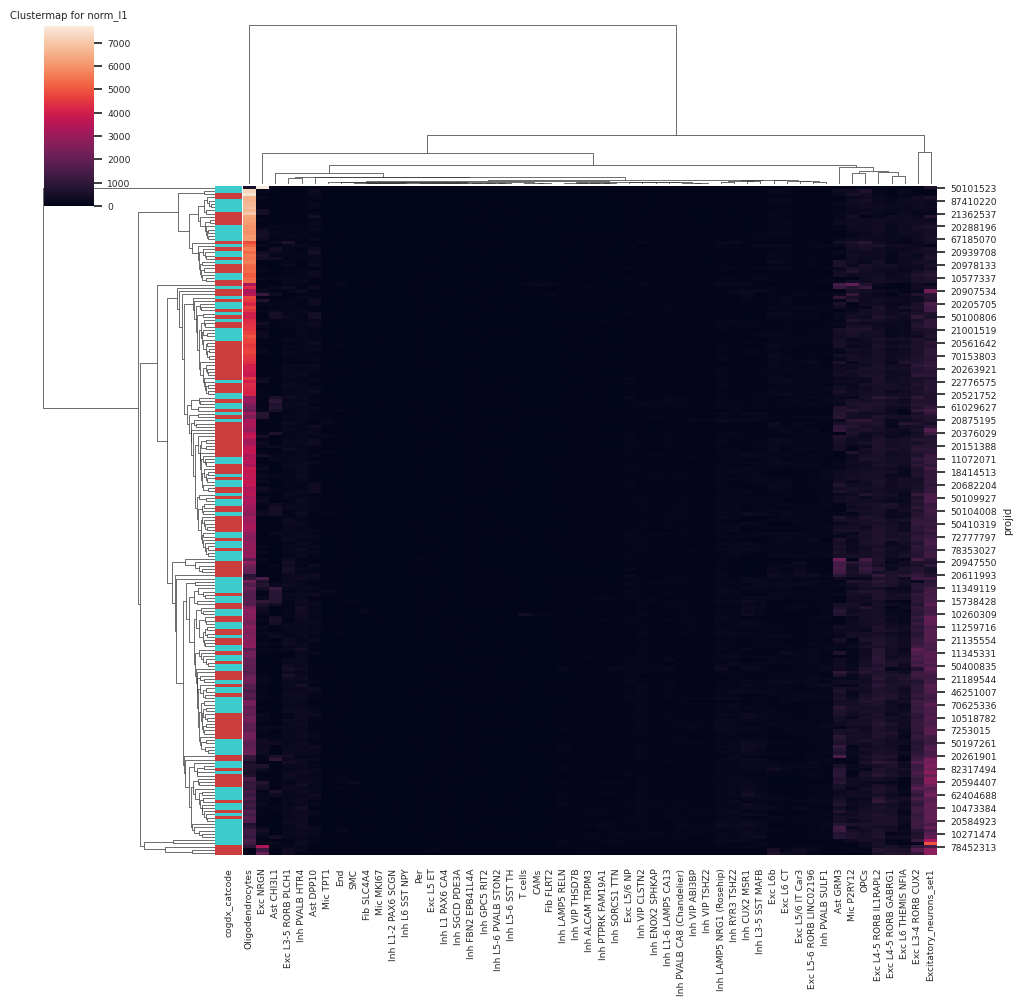

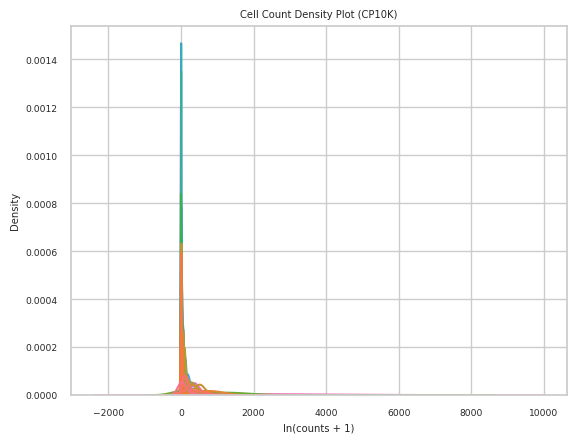

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


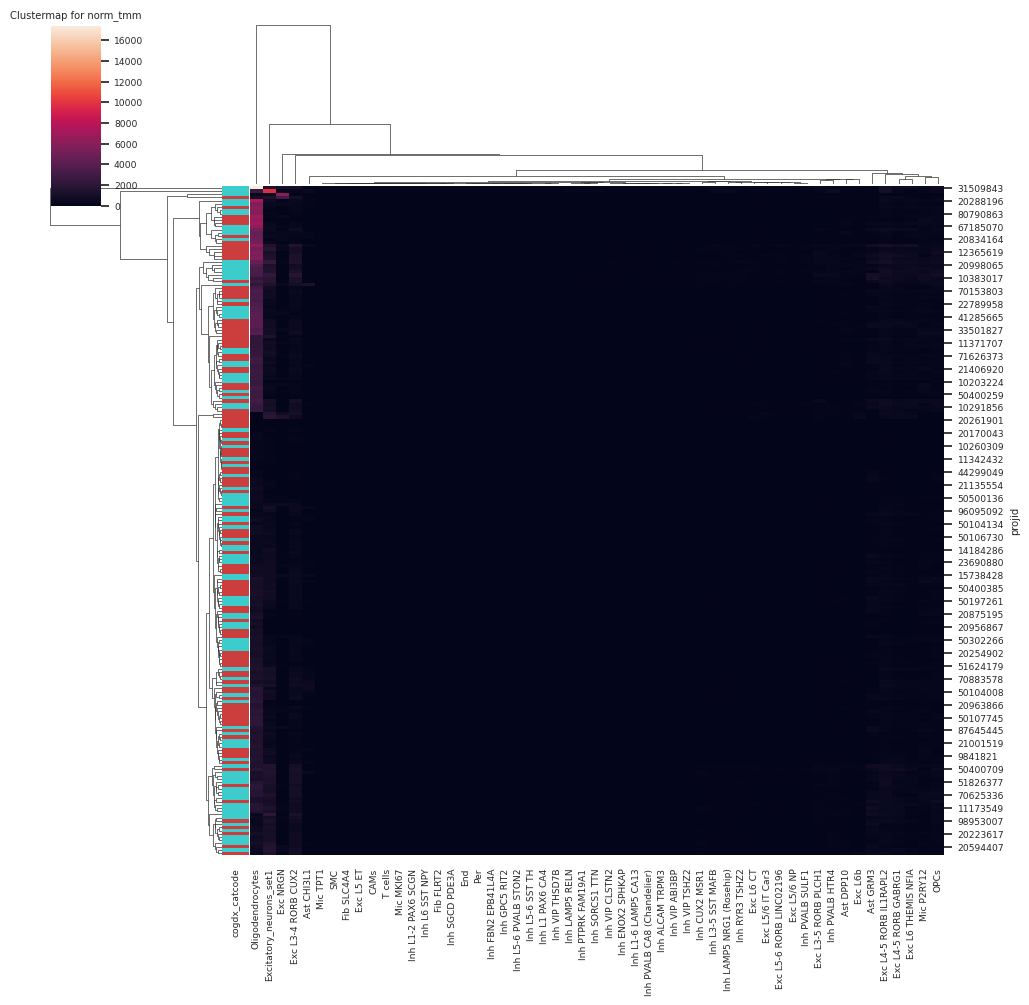

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


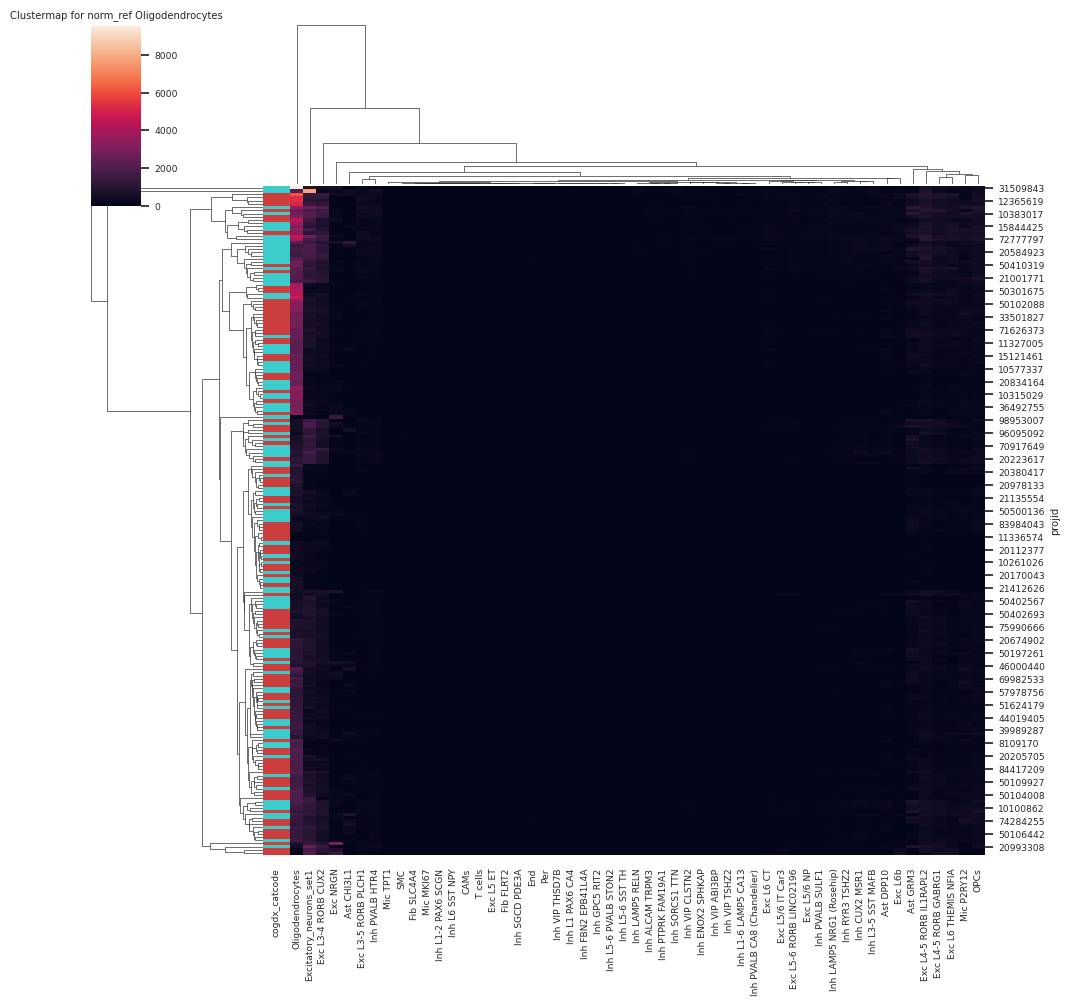

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


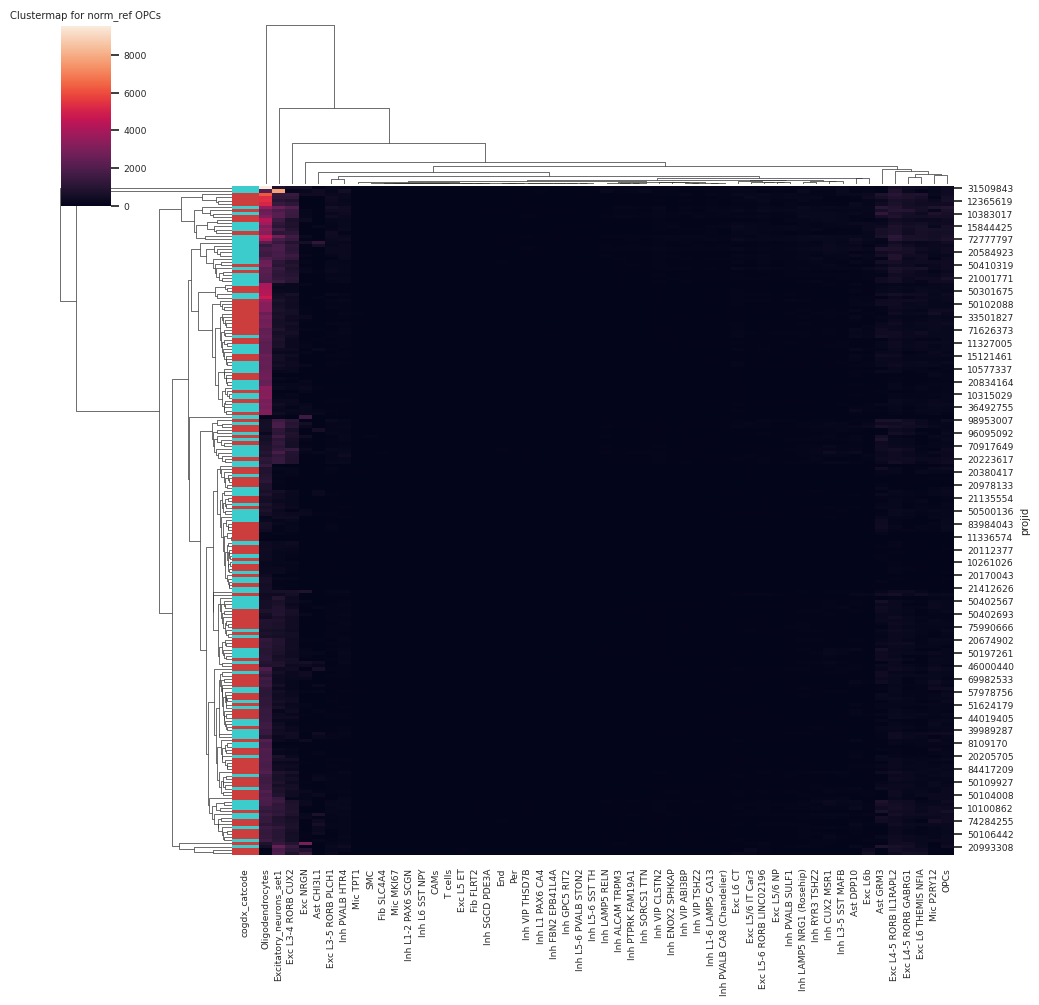

In [6]:
# Normalize the data
kwargs = {'tmm' : {'trim_lfc': 0.1}}
normalizer = Normalizer(['l1', 'tmm', 'ref Oligodendrocytes', 'ref OPCs'], None, keyword_args=kwargs)
normalizer.normalize_all(ct_counts_metadata)

for layer in normalizer.layer_names:
    generate_clustermap(ct_counts_metadata, layer, 'cogdx_catcode')
    if layer == 'norm_l1':
        generate_densityplot(ct_counts_metadata, layer, override_title='Cell Count Density Plot (CP10K)', xlabel='ln(counts + 1)')

In [7]:
# Differential abundance
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

diff = Differentiator('l1', ranksums, fdrcorrection, 'cogdx_cat', ('AD', 'H'))
diff.differentiate(ct_counts_metadata)

log2( fold change ) = log2( AD/H )


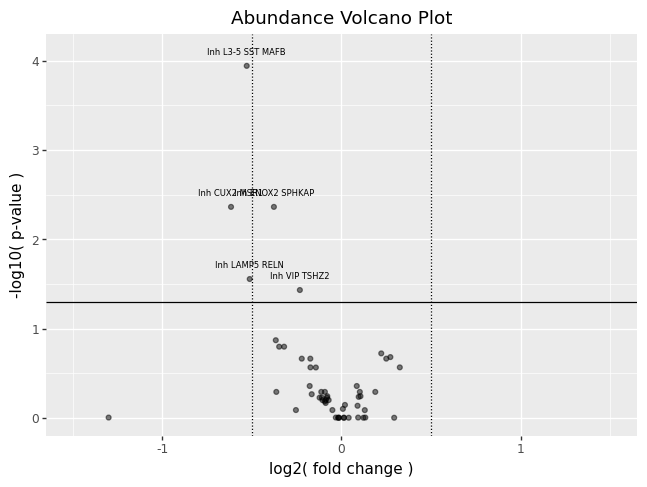

In [8]:
diff.volcano_plot(ct_counts_metadata)

In [9]:
#diff_nonorm = Differentiator(None, ranksums, fdrcorrection, 'cogdx_cat', ('AD', 'H'))
#diff_nonorm.differentiate(ct_counts_metadata)
#diff_nonorm.volcano_plot(ct_counts_metadata)

# TODO: Differentiator does not support no normalization yet...

In [10]:
diff.abundance_df.sort_values('corr_pvalue')

,significant,corr_pvalue,log2fc,log10p
Inh L3-5 SST MAFB,True,0.000114,-0.528667,3.943107
Inh ENOX2 SPHKAP,True,0.004321,-0.377019,2.364392
Inh CUX2 MSR1,True,0.004321,-0.616244,2.364392
Inh LAMP5 RELN,True,0.027735,-0.511902,1.556965
Inh VIP TSHZ2,True,0.036842,-0.232193,1.433656
Inh PTPRK FAM19A1,False,0.134324,-0.366515,0.871848
Inh SORCS1 TTN,False,0.158701,-0.347577,0.799422
Inh L1 PAX6 CA4,False,0.158701,-0.320120,0.799422
Exc L6 THEMIS NFIA,False,0.188623,0.221929,0.724405
Mic P2RY12,False,0.207433,0.272835,0.683123


log2( fold change ) = log2( AD/H )


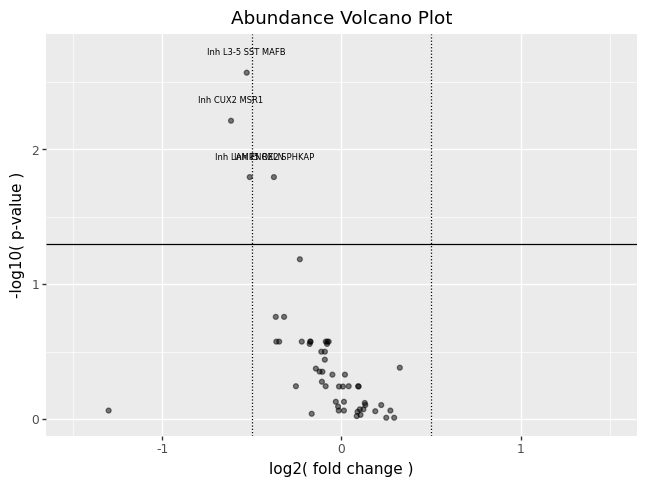

In [11]:
diff_tmm = Differentiator('tmm', ranksums, fdrcorrection, 'cogdx_cat', ('AD', 'H'))
diff_tmm.differentiate(ct_counts_metadata)
diff_tmm.volcano_plot(ct_counts_metadata)

In [12]:
diff_tmm.abundance_df.sort_values('corr_pvalue')

,significant,corr_pvalue,log2fc,log10p
Inh L3-5 SST MAFB,True,0.002701,-0.528667,2.568398
Inh CUX2 MSR1,True,0.006138,-0.616244,2.212008
Inh ENOX2 SPHKAP,True,0.016073,-0.377019,1.793903
Inh LAMP5 RELN,True,0.016073,-0.511902,1.793903
Inh VIP TSHZ2,False,0.065385,-0.232193,1.184521
Inh L1 PAX6 CA4,False,0.174894,-0.320120,0.757226
Inh PTPRK FAM19A1,False,0.174894,-0.366515,0.757226
Fib FLRT2,False,0.266999,-0.071435,0.573490
Inh L5-6 SST TH,False,0.266999,-0.221536,0.573490
OPCs,False,0.266999,-0.078946,0.573490


In [13]:
# Split test and train
ct_counts_metadata, ct_counts_metadata_test = ModelTester.split_test_data(ct_counts_metadata, 0.15, 'cogdx_cat', random_state=42)

train_adata.shape=(175, 53)
test_adata.shape=(32, 53)


In [14]:
# Custom feature selection
filtered_ct_counts = pp.keep_features(ct_counts_metadata, diff.abundance_df.sort_values('corr_pvalue').head(25).index.to_list())

In [15]:
# Test models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

base_opt = ModelTester(None, DecisionTreeClassifier(), 'cogdx_catcode', [0, 1], 15, random_state=42)
base_opt.test_baseline(ct_counts_metadata, 'DT (Base)')

grid_params = {'max_depth': np.arange(2, 20)}
base_opt.exhaustive_gridsearch(ct_counts_metadata, base_opt.baseline_model, 'DT', grid_params)

Fitting GridSearchCV... done!


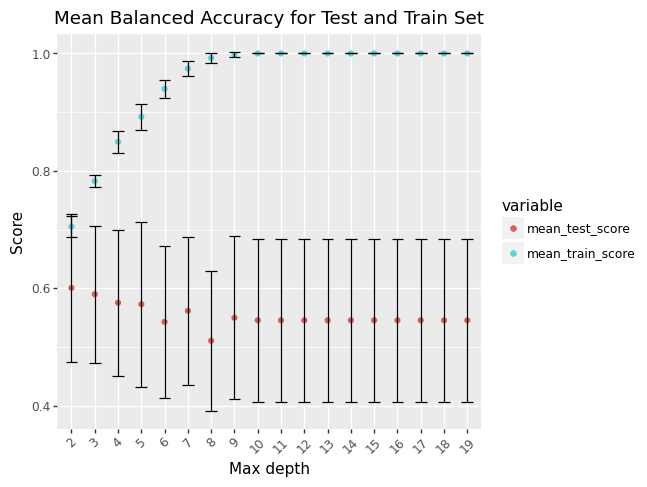

In [16]:
base_opt.plot_overfit('DT', 'param_max_depth', 'mean', 'Mean Balanced Accuracy for Test and Train Set')

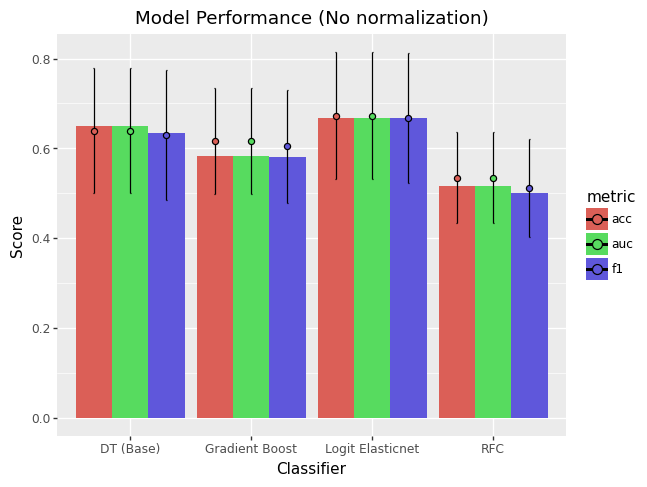

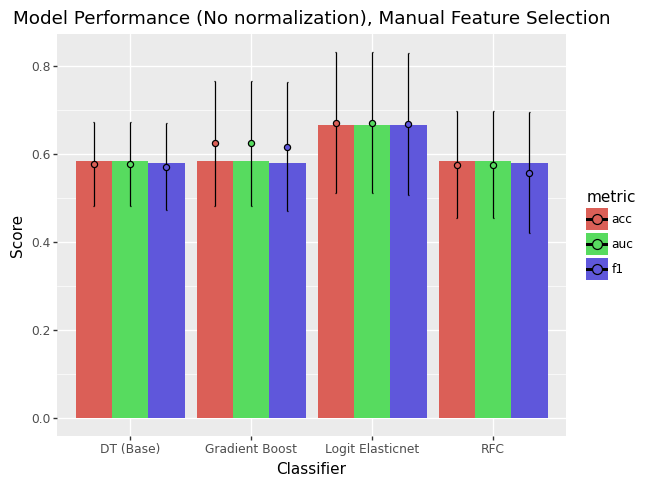

In [17]:
tester = ModelTester(None, DecisionTreeClassifier(max_depth=10), 'cogdx_catcode', [0, 1], 15, random_state=42, verbose=False)
tester.test_baseline(ct_counts_metadata, 'DT (Base)')
tester.test_models(ct_counts_metadata, 
                   [RandomForestClassifier(class_weight='balanced'), GradientBoostingClassifier(), LogisticRegression('elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)], 
                   ['RFC', 'Gradient Boost', 'Logit Elasticnet'])
tester.plot_results('Model Performance (No normalization)')

ftester = ModelTester(None, DecisionTreeClassifier(max_depth=10), 'cogdx_catcode', [0, 1], 15, random_state=42, verbose=False)
ftester.test_baseline(filtered_ct_counts, 'DT (Base)')
ftester.test_models(filtered_ct_counts, 
                   [RandomForestClassifier(class_weight='balanced'), GradientBoostingClassifier(), LogisticRegression('elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)], 
                   ['RFC', 'Gradient Boost', 'Logit Elasticnet'])
ftester.plot_results('Model Performance (No normalization), Manual Feature Selection')

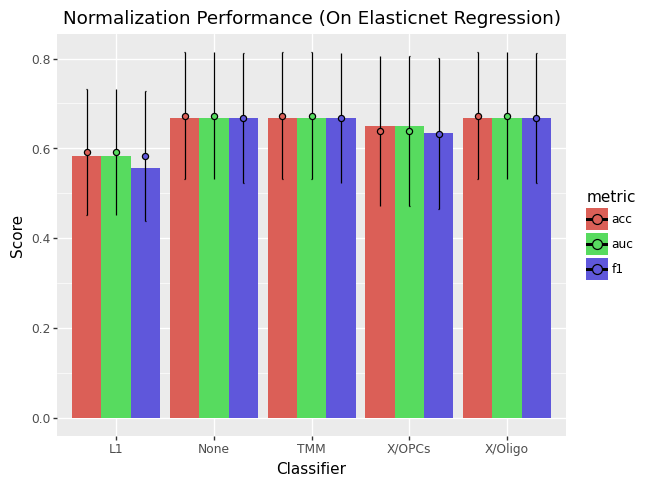

In [18]:
norm_tester = ModelTester(normalizer, LogisticRegression('elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000), 'cogdx_catcode', [0, 1], 15, random_state=42, verbose=False)
norm_tester.test_baseline(ct_counts_metadata, 'None')
norm_tester.test_normalizations(ct_counts_metadata, ['L1', 'X/OPCs', 'X/Oligo', 'TMM'])
norm_tester.plot_results('Normalization Performance (On Elasticnet Regression)')

In [19]:
# Grid search

opt_tester = ModelTester(normalizer, DecisionTreeClassifier(max_depth=10), 'cogdx_catcode', (0, 1), 15, random_state=42)

param_dict = {'l1_ratio': np.arange(0, 1, 0.1), 'C': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]}
opt_tester.exhaustive_gridsearch(ct_counts_metadata,
                    LogisticRegression('elasticnet', solver='saga', max_iter=10000),
                    'Logit Elasticnet',
                    param_dict,
                    normalization_idx=1,
                    save_type='full',
                    file_name='elasticnet_allfeat_tmm_notrans.csv',
                    override_file=False)

Retrieving previous results... done! Stopping here...


In [20]:
param_dict = {'n_estimators': [25, 50, 100, 200, 300], 
              'max_features': ['sqrt', 'log2'], 
              'max_leaf_nodes': [4, 8, 12, 16, 24, 32, 48], 
              'min_samples_split': np.arange(2, 21)}
opt_tester.exhaustive_gridsearch(ct_counts_metadata,
                                  RandomForestClassifier(class_weight='balanced'),
                                  'RFC',
                                  param_dict,
                                  normalization_idx=1,
                                  save_type='full',
                                  file_name='randomfor_allfeat_tmm_notrans.csv',
                                  override_file=False)

Retrieving previous results... done! Stopping here...


In [21]:
param_dict = {'n_estimators': [25, 50, 100, 200, 300], 
              'max_features': ['sqrt', 'log2'], 
              'max_leaf_nodes': [4, 8, 12, 16, 24, 32, 48], 
              'min_samples_split': np.arange(2, 21)}
opt_tester.exhaustive_gridsearch(ct_counts_metadata,
                                  GradientBoostingClassifier(),
                                  'Gradient Boost',
                                  param_dict,
                                  normalization_idx=1,
                                  save_type='full',
                                  file_name='gradboost_allfeat_tmm_notrans.csv',
                                  override_file=False)

Retrieving previous results... done! Stopping here...


In [22]:
display(opt_tester.gridsearch_results_summary['Logit Elasticnet'].sort_values(['median_test_score', 'mean_test_score'], ascending=[False, False]))
display(opt_tester.gridsearch_results_summary['RFC'].sort_values(['median_test_score', 'mean_test_score'], ascending=[False, False]))
display(opt_tester.gridsearch_results_summary['Gradient Boost'].sort_values(['median_test_score', 'mean_test_score'], ascending=[False, False]))

,param_C,param_l1_ratio,params,mean_test_score,std_test_score,mean_train_score,std_train_score,median_test_score,median_train_score
31,0.00050,0.1,"{'C': 0.0005, 'l1_ratio': 0.1}",0.603968,0.175159,0.694721,0.020572,0.642857,0.688386
42,0.00100,0.2,"{'C': 0.001, 'l1_ratio': 0.2}",0.603968,0.175159,0.697258,0.017501,0.642857,0.691512
51,0.00500,0.1,"{'C': 0.005, 'l1_ratio': 0.1}",0.590952,0.178953,0.741799,0.016055,0.614286,0.739464
62,0.01000,0.2,"{'C': 0.01, 'l1_ratio': 0.2}",0.590952,0.178953,0.741799,0.016055,0.614286,0.739464
77,0.05000,0.7,"{'C': 0.05, 'l1_ratio': 0.7000000000000001}",0.590952,0.178953,0.743000,0.015702,0.614286,0.743112
...,...,...,...,...,...,...,...,...,...
24,0.00010,0.4,"{'C': 0.0001, 'l1_ratio': 0.4}",0.451111,0.075392,0.529885,0.049376,0.483333,0.500000
0,0.00001,0.0,"{'C': 1e-05, 'l1_ratio': 0.0}",0.557302,0.175407,0.694339,0.012973,0.466667,0.695324
21,0.00010,0.1,"{'C': 0.0001, 'l1_ratio': 0.1}",0.513968,0.146751,0.552204,0.044657,0.466667,0.558974
35,0.00050,0.5,"{'C': 0.0005, 'l1_ratio': 0.5}",0.513968,0.146751,0.552204,0.044657,0.466667,0.558974


,param_max_features,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,mean_test_score,std_test_score,mean_train_score,std_train_score,median_test_score,median_train_score
1072,log2,24,7,100,"{'max_features': 'log2', 'max_leaf_nodes': 24,...",0.582381,0.150737,0.997255,0.002935,0.585714,1.000000
1167,log2,32,7,100,"{'max_features': 'log2', 'max_leaf_nodes': 32,...",0.582381,0.150737,0.997255,0.002935,0.585714,1.000000
1262,log2,48,7,100,"{'max_features': 'log2', 'max_leaf_nodes': 48,...",0.582381,0.150737,0.997255,0.002935,0.585714,1.000000
442,sqrt,24,14,100,"{'max_features': 'sqrt', 'max_leaf_nodes': 24,...",0.581587,0.129346,0.981948,0.006609,0.583333,0.981906
537,sqrt,32,14,100,"{'max_features': 'sqrt', 'max_leaf_nodes': 32,...",0.581587,0.129346,0.981948,0.006609,0.583333,0.981906
...,...,...,...,...,...,...,...,...,...,...,...
135,sqrt,8,10,25,"{'max_features': 'sqrt', 'max_leaf_nodes': 8, ...",0.488254,0.133711,0.901731,0.018880,0.433333,0.902187
130,sqrt,8,9,25,"{'max_features': 'sqrt', 'max_leaf_nodes': 8, ...",0.478254,0.145320,0.902152,0.014160,0.433333,0.895777
876,log2,12,6,50,"{'max_features': 'log2', 'max_leaf_nodes': 12,...",0.503968,0.164713,0.968577,0.009538,0.416667,0.970060
870,log2,12,5,25,"{'max_features': 'log2', 'max_leaf_nodes': 12,...",0.489524,0.181505,0.944643,0.010615,0.416667,0.945272


,param_max_features,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,mean_test_score,std_test_score,mean_train_score,std_train_score,median_test_score,median_train_score
762,log2,8,2,100,"{'max_features': 'log2', 'max_leaf_nodes': 8, ...",0.571587,0.157243,1.0,0.0,0.583333,1.0
857,log2,12,2,100,"{'max_features': 'log2', 'max_leaf_nodes': 12,...",0.571587,0.157243,1.0,0.0,0.583333,1.0
952,log2,16,2,100,"{'max_features': 'log2', 'max_leaf_nodes': 16,...",0.571587,0.157243,1.0,0.0,0.583333,1.0
1047,log2,24,2,100,"{'max_features': 'log2', 'max_leaf_nodes': 24,...",0.571587,0.157243,1.0,0.0,0.583333,1.0
1142,log2,32,2,100,"{'max_features': 'log2', 'max_leaf_nodes': 32,...",0.571587,0.157243,1.0,0.0,0.583333,1.0
...,...,...,...,...,...,...,...,...,...,...,...
352,sqrt,16,15,100,"{'max_features': 'sqrt', 'max_leaf_nodes': 16,...",0.484286,0.142602,1.0,0.0,0.416667,1.0
447,sqrt,24,15,100,"{'max_features': 'sqrt', 'max_leaf_nodes': 24,...",0.484286,0.142602,1.0,0.0,0.416667,1.0
542,sqrt,32,15,100,"{'max_features': 'sqrt', 'max_leaf_nodes': 32,...",0.484286,0.142602,1.0,0.0,0.416667,1.0
637,sqrt,48,15,100,"{'max_features': 'sqrt', 'max_leaf_nodes': 48,...",0.484286,0.142602,1.0,0.0,0.416667,1.0


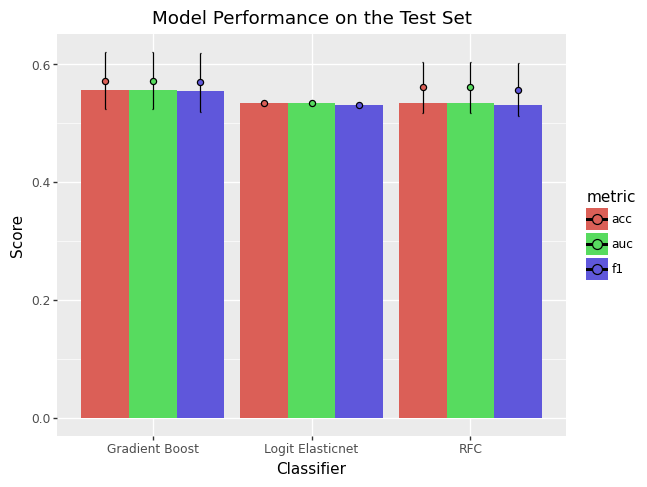

In [23]:
# Retest models

random_states = np.random.randint(0, 1000, size=30)
if 42 not in random_states:
    random_states[0] = 42

opt_tester.run_final_test(ct_counts_metadata, ct_counts_metadata_test, random_states, 'tmm')
opt_tester.plot_final_results('Model Performance on the Test Set', plot_type='bar')